In [5]:
import os

import pandas as pd
import numpy as np
import imageio.v2 as imageio

from graphviz import Digraph
from IPython.display import Image

In [206]:
mc_example = {'NYC': [.25,0,.75,1],
              'Paris': [.25,.25,0,0],
              'Cairo': [.25,.25,.25,0],
              'Seoul': [.25,.5,0,0]}

mc = pd.DataFrame(data = mc_example, index = ['NYC', 'Paris', 'Cairo', 'Seoul'])
mc

,NYC,Paris,Cairo,Seoul
NYC,0.25,0.25,0.25,0.25
Paris,0.00,0.25,0.25,0.50
Cairo,0.75,0.00,0.25,0.00
Seoul,1.00,0.00,0.00,0.00


In [212]:
mc.iloc[0].index

Index(['NYC', 'Paris', 'Cairo', 'Seoul'], dtype='object')

In [137]:
mc.iloc[0]

NYC      0.25
Paris    0.25
Cairo    0.25
Seoul    0.25
Name: NYC, dtype: float64

In [138]:
np.random.choice(mc.iloc[0].index, p=mc.iloc[0])

'Seoul'

In [139]:
mc.index.get_loc('Paris')

1

In [140]:
mc.iloc[mc.index.get_loc('Paris')].index

Index(['NYC', 'Paris', 'Cairo', 'Seoul'], dtype='object')

In [141]:
mc.iloc[mc.index.get_loc('Paris')]

NYC      0.00
Paris    0.25
Cairo    0.25
Seoul    0.50
Name: Paris, dtype: float64

In [142]:
travel_sim = []

# get row 0th, then get index of item 0th -> NYC
city = mc.iloc[3].index[3]

# append into travel_sim
travel_sim.append(city)

# get the next visited city randomly choice based on known probability
travel_sim.append(np.random.choice(mc.iloc[0].index, # get index of row 0th
                                   p=mc.iloc[0] # get probability of row 0th
                                   ))
print('first print', travel_sim)

# get the next city using previous city probability
while len(travel_sim)<25:
    city = np.random.choice(mc.iloc[mc.index.get_loc(city)].index,
                            p = mc.iloc[mc.index.get_loc(city)]
                            )
    travel_sim.append(city)
travel_sim


first print ['Seoul', 'NYC']


['Seoul',
 'NYC',
 'NYC',
 'NYC',
 'Seoul',
 'NYC',
 'Seoul',
 'NYC',
 'NYC',
 'Paris',
 'Paris',
 'Cairo',
 'NYC',
 'Paris',
 'Paris',
 'Seoul',
 'NYC',
 'NYC',
 'NYC',
 'NYC',
 'Cairo',
 'NYC',
 'Cairo',
 'NYC',
 'NYC']

In [143]:
def matrix_power(matrix, power):
  if power == 0:
    return np.identity(len(matrix))
  elif power == 1:
    return matrix
  else:
    return np.dot(matrix, matrix_power(matrix, power-1))
     

In [144]:
matrix_power(mc.to_numpy(), 2)

array([[0.5   , 0.125 , 0.1875, 0.1875],
       [0.6875, 0.0625, 0.125 , 0.125 ],
       [0.375 , 0.1875, 0.25  , 0.1875],
       [0.25  , 0.25  , 0.25  , 0.25  ]])

In [145]:
initial_dist = np.asarray([0,0,0,1])

mc_p2 = matrix_power(mc.to_numpy(),2)
print(mc_p2)
np.dot(initial_dist,mc_p2)

[[0.5    0.125  0.1875 0.1875]
 [0.6875 0.0625 0.125  0.125 ]
 [0.375  0.1875 0.25   0.1875]
 [0.25   0.25   0.25   0.25  ]]


array([0.25, 0.25, 0.25, 0.25])

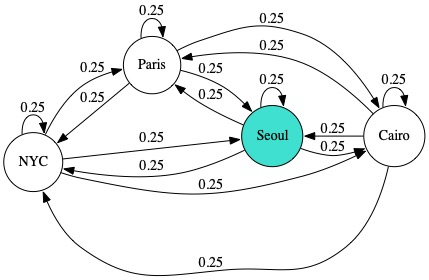

In [214]:
def baseline_data(region_list):
    data = {}
    region_count = len(region_list)
    for i in region_list:
        data[i] = [1/region_count]*region_count
    
    # convert matrix to dataframe
    df = pd.DataFrame(data = data,
                      index = [*data]) #list of data keys
    return df

def preprocess_data(df):
    # convert adjacency matrix into edgelist table
    df = df.rename_axis('source')\
            .reset_index()\
            .melt('source', value_name='weight', var_name='target')\
            .reset_index(drop=True)
    return df

# Input data from dataframe into graph network
def create_graph_network(df, colored):
    # Declare Graph Network Template
    G = Digraph(format='jpeg')
    G.attr(rankdir='LR', size='8,5')
    G.attr('node', shape='circle')
    
    nodelist = []
    for idx, row in df.iterrows():
        node1, node2, weight = [str(i) for i in row]
        
        if float(weight) == 0.0:
            continue
        else:
            
            if node1 not in nodelist:
                if node1 == colored:
                    G.node(node1, style='filled', fillcolor='#40e0d0')
                else:
                    G.node(node1)
                nodelist.append(node2)
            if node2 not in nodelist:
                if node2 == colored:
                    G.node(node2, style='filled', fillcolor='#40e0d0')
                else:
                    G.node(node2)
                nodelist.append(node2)

            G.edge(node1,node2, label = weight)
    
    # render graph and save as image
    fname = f'./markov_chain_{colored}'
    G.render(fname, view=False)
    save_as = f'{fname}.jpeg'
    return save_as

# declare matrix
region_list = ['NYC', 'Paris', 'Cairo', 'Seoul']
data = baseline_data(region_list)

# preprocess data
df = preprocess_data(data)

# render graph network
colored_list = ['NYC', 'Paris', 'Cairo', 'Seoul']
for i in colored_list:
    save_as = create_graph_network(df, i)
# show image in jupyter
Image(save_as)

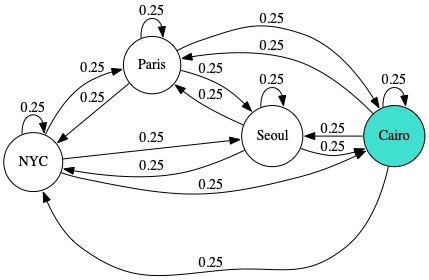

In [205]:
def generate_gif(png_dir = './',
                 save_as = './markov_chain.gif',
                 duration=1000):
    images = []
    for file_name in sorted(os.listdir(png_dir)):
        if file_name.endswith('.jpeg'):
            file_path = os.path.join(png_dir, file_name)
            images.append(imageio.imread(file_path))
    imageio.mimsave(save_as, images, 'GIF', duration=duration)
    return save_as
gif_img = generate_gif()
Image(gif_img)

In [254]:
def block_nodes(df, node_1, node_2):
    # set edge between node_1 and node_2 to 0
    df.at[node_1, node_2] = 0
    df.at[node_2, node_1] = 0
    
    # get node index loc
    node_1_idx = df.index.get_loc(node_1)
    node_2_idx = df.index.get_loc(node_2)
    
    # region count
    region_list = df.index.to_list()
    region_count = len(region_list)
    
    # re-calculate other edge values
    node_1_prob_list = [1/(region_count-1)]*region_count
    node_1_prob_list[node_2_idx] = 0
    df.loc[df.index == node_1, region_list] = node_1_prob_list
    
    node_2_prob_list = [1/(region_count-1)]*region_count
    node_2_prob_list[node_1_idx] = 0
    df.loc[df.index == node_2, region_list] = node_2_prob_list
    df = df.round(2)
    return df
block_nodes(baseline_data(region_list), 'NYC', 'Seoul')

0 3


,NYC,Paris,Cairo,Seoul
NYC,0.33,0.33,0.33,0.00
Paris,0.25,0.25,0.25,0.25
Cairo,0.25,0.25,0.25,0.25
Seoul,0.00,0.33,0.33,0.33
